In [138]:
#libraries
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_point, geom_line
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



Our goal will be to fit models that identify the Sativa types from the Indica types, and then to fit models that also distinguish the Hybrid types.

IMPORTANT: In this assignment, you do not need to consider different feature sets. Normally, this would be a good thing to try - but for this homework, simply include all the predictors for every model.

In [139]:
# data set link:
# https://www.dropbox.com/s/s2a1uoiegitupjc/cannabis_full.csv

cannabis = pd.read_csv('data/cannabis_full.csv')

In [140]:
#deal with NA's
#get NA counts for each variable
na_counts = cannabis.isna().sum()
#print(na_counts)

#its terrible practice to delete all na's but in this case there are only around 160ish and our dataset has 2.3k observations so hopefully it wont impact the results that much
cannabis_clean = cannabis.dropna()

In [141]:
cannabis_clean = cannabis.dropna()

**Part One: Binary Classification**

Create a dataset that is limited only to the Sativa and Indica type cannabis strains.

This section asks you to create a final best model for each of the four new model types studied this week: LDA, QDA, SVC, and SVM. For SVM, you may limit yourself to only the polynomial kernel.

For each, you should:

* Choose a metric you will use to select your model, and briefly justify your choice. (Hint: There is no specific target category here, so this should not be a metric that only prioritizes one category.)

* Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

* Report the (cross-validated!) metric.

* Fit the final model.

* Output a confusion matrix.

In [142]:
#dataset including only sativa and indica
cannabis_binary = cannabis_clean[(cannabis['Type'] == "sativa") | (cannabis_clean['Type'] == "indica")]

<positron-console-cell-142>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [143]:
#variable selection
X = cannabis_binary.drop(["Type"], axis = 1)
y = cannabis_binary["Type"]

In [144]:
#split to train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [145]:
#column transformer
ct = ColumnTransformer(
  [
    ("dummify", 
    #handle_unknown: ignore observations for unknown values in category variable
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

**Q1: LDA**

Metric Selection: because our variable is binary, accuracy is a valid scoring metric to use for LDA

In [146]:
#pipeline
lr_pipeline_linear_disc = Pipeline(
  [("preprocessing", ct),
  ("linear_disc_analysis", LinearDiscriminantAnalysis(solver = "lsqr", shrinkage = "auto"))]
).set_output(transform="pandas")

In [147]:
#hypertune
parameters = {
    "linear_disc_analysis__solver": ["svd", "lsqr", "eigen"],
    "linear_disc_analysis__shrinkage": [None, "auto", 0.1, 0.5, 0.9]}


gscv = GridSearchCV(lr_pipeline_linear_disc, parameters, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
26 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.

,linear_disc_analysis__shrinkage,linear_disc_analysis__solver,scores
4,auto,lsqr,0.867044
5,auto,eigen,0.867044
13,0.9,lsqr,0.862375
14,0.9,eigen,0.862375
10,0.5,lsqr,0.860493


Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

In [148]:
#fit data using final model
lr_pipeline_linear_disc.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3491ea9c0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x30b494a70>)])),
                ('linear_disc_analysis',
                 LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'))])

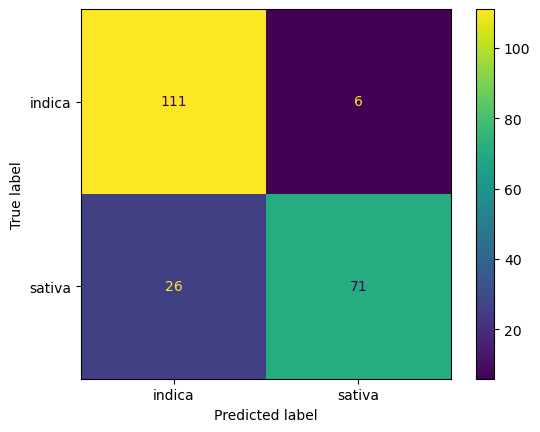

In [149]:
#get confusion matrix

# predict y's on X_test
y_pred = lr_pipeline_linear_disc.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
lda_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_pipeline_linear_disc.named_steps['linear_disc_analysis'].classes_)
lda_cm.plot()

# extract all the values from the confusion matrix
tn_lda, fp_lda, fn_lda, tp_lda = cm.ravel()

**QDA**

In [150]:
#pipeline
lr_pipeline_quad_disc = Pipeline(
  [("preprocessing", ct),
  ("quad_disc_analysis", QuadraticDiscriminantAnalysis(reg_param = 1))]
).set_output(transform="pandas")

In [151]:
#hypertune
parameters = {
    "quad_disc_analysis__reg_param": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}


gscv = GridSearchCV(lr_pipeline_quad_disc, parameters, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


,quad_disc_analysis__reg_param,scores
10,1.0,0.846453
0,0.0,0.692962
9,0.9,0.624558
3,0.3,0.620785
1,0.1,0.617981


Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

In [152]:
#fit data using final model
lr_pipeline_quad_disc.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3491ea9c0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x30b494a70>)])),
                ('quad_disc_analysis',
                 QuadraticDiscriminantAnalysis(reg_param=1))])

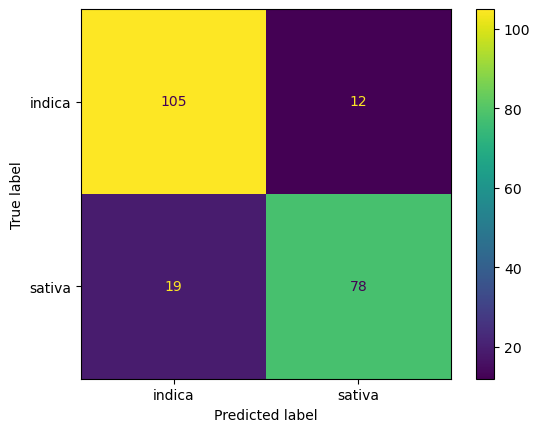

In [153]:
#get confusion matrix

# predict y's on X_test
y_pred = lr_pipeline_quad_disc.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
lda_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_pipeline_quad_disc.named_steps['quad_disc_analysis'].classes_)
lda_cm.plot()

# extract all the values from the confusion matrix
tn_lda, fp_lda, fn_lda, tp_lda = cm.ravel()

**SVC (linear)**

In [154]:
#pipeline
lr_pipeline_support_vector_class = Pipeline(
  [("preprocessing", ct),
  #use kernel = 'linear' like from practice activity, still want to tune C
  ("support_vector_class", SVC(C = 0.1, kernel = 'linear'))]
).set_output(transform="pandas")

In [155]:
#tune c
cs = {"support_vector_class__C": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_support_vector_class, cs, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

,support_vector_class__C,scores
2,0.100,0.855816
3,1.000,0.854859
4,10.000,0.854859
5,100.000,0.854859
1,0.010,0.853947
0,0.001,0.851130


Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

In [156]:
#fit data using final model
lr_pipeline_support_vector_class.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3491ea9c0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x30b494a70>)])),
                ('support_vector_class', SVC(C=0.1, kernel='linear'))])

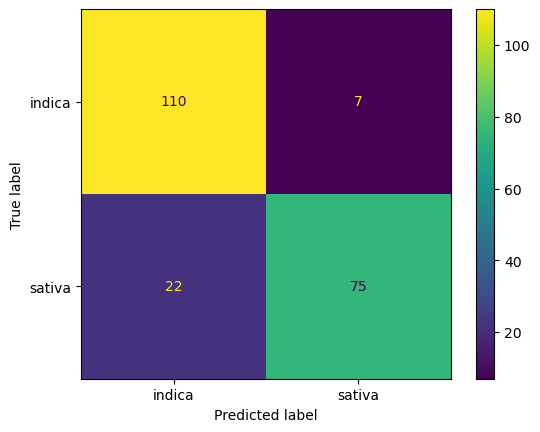

In [157]:
#get confusion matrix

# predict y's on X_test
y_pred = lr_pipeline_support_vector_class.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
lda_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_pipeline_support_vector_class.named_steps['support_vector_class'].classes_)
lda_cm.plot()

# extract all the values from the confusion matrix
tn_lda, fp_lda, fn_lda, tp_lda = cm.ravel()

**SVM (non-linear)**

In [158]:
#pipeline
lr_pipeline_support_vector_machine = Pipeline(
  [("preprocessing", ct),
  #use kernel = 'linear' like from practice activity, still want to tune C
  ("support_vector_machine", SVC(C = 1, kernel = 'rbf'))]
).set_output(transform="pandas")

In [159]:
#tune c
cs = {"support_vector_machine__C": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_support_vector_machine, cs, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

,support_vector_machine__C,scores
3,1.000,0.840876
4,10.000,0.838980
5,100.000,0.836177
2,0.100,0.795902
0,0.001,0.617042
1,0.010,0.617042


Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

In [160]:
#fit data using final model
lr_pipeline_support_vector_machine.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3491ea9c0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x30b494a70>)])),
                ('support_vector_machine', SVC(C=1))])

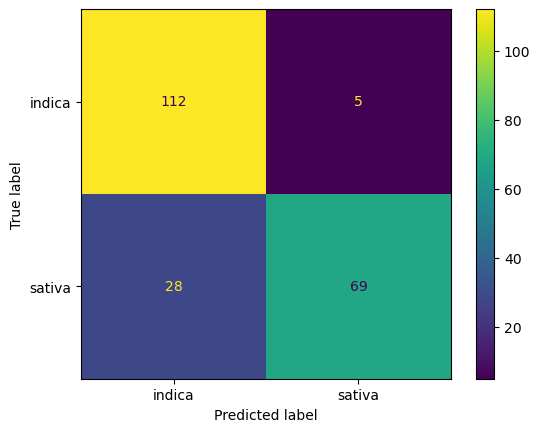

In [161]:
#get confusion matrix

# predict y's on X_test
y_pred = lr_pipeline_support_vector_machine.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
lda_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_pipeline_support_vector_machine.named_steps['support_vector_machine'].classes_)
lda_cm.plot()

# extract all the values from the confusion matrix
tn_lda, fp_lda, fn_lda, tp_lda = cm.ravel()

**Part Two: Natural Multiclass**

Now use the full dataset, including the Hybrid strains.

In [162]:
#variable selection
X = cannabis_clean.drop(["Type"], axis = 1)
y = cannabis_clean["Type"]

In [163]:
#split to train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Q1**

Fit a decision tree, plot the final fit, and interpret the results.

In [164]:
#decision tree pipeline
decision_tree_pipeline = Pipeline([
    ("preprocessing", ct),
    ("decision_tree_classifier", DecisionTreeClassifier(ccp_alpha = .01))
]).set_output(transform = "pandas")

In [165]:
#tune c
cs = {"decision_tree_classifier__ccp_alpha": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(decision_tree_pipeline, cs, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

,decision_tree_classifier__ccp_alpha,scores
1,0.010,0.613875
0,0.001,0.576004
2,0.100,0.512551
3,1.000,0.512551
4,10.000,0.512551
5,100.000,0.512551


[Text(0.6, 0.8333333333333334, 'x[5095] <= 0.367\ngini = 0.612\nsamples = 2191\nvalue = [1123, 659, 409]'),
 Text(0.4, 0.5, 'x[5084] <= 0.481\ngini = 0.55\nsamples = 1473\nvalue = [889.0, 203.0, 381.0]'),
 Text(0.2, 0.16666666666666666, 'gini = 0.507\nsamples = 884\nvalue = [581, 179, 124]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.535\nsamples = 589\nvalue = [308.0, 24.0, 257.0]'),
 Text(0.8, 0.5, 'gini = 0.489\nsamples = 718\nvalue = [234.0, 456.0, 28.0]')]

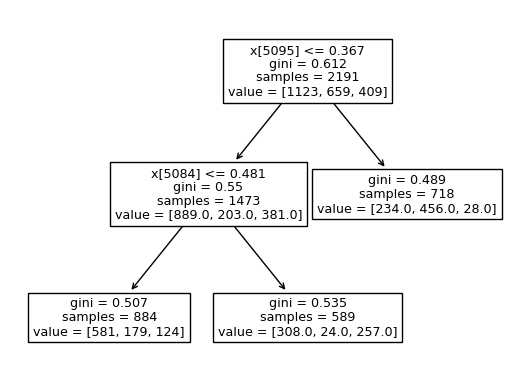

In [166]:
#fit tree
decision_tree_pipeline.fit(X,y)

tree = decision_tree_pipeline.named_steps['decision_tree_classifier']

plot_tree(tree)

[Text(0.6, 0.8333333333333334, 'standardize__Sleepy <= 0.367\ngini = 0.612\nsamples = 2191\nvalue = [1123, 659, 409]\nclass = hybrid'),
 Text(0.4, 0.5, 'standardize__Energetic <= 0.481\ngini = 0.55\nsamples = 1473\nvalue = [889.0, 203.0, 381.0]\nclass = hybrid'),
 Text(0.2, 0.16666666666666666, 'gini = 0.507\nsamples = 884\nvalue = [581, 179, 124]\nclass = hybrid'),
 Text(0.6, 0.16666666666666666, 'gini = 0.535\nsamples = 589\nvalue = [308.0, 24.0, 257.0]\nclass = hybrid'),
 Text(0.8, 0.5, 'gini = 0.489\nsamples = 718\nvalue = [234.0, 456.0, 28.0]\nclass = indica')]

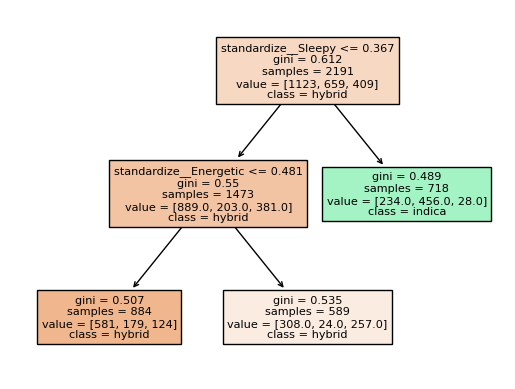

In [167]:
#names from the preprocessing step
feature_names = ct.get_feature_names_out()
# target class names
class_names = tree.classes_.astype(str)

plot_tree(
    tree,
    #names from the preprocessing step
    feature_names=feature_names, 
    # target class names
    class_names=class_names, 
    # color nodes by class
    filled=True,
)


RESULT INTERPRETATION

**Q2**

Repeat the analyses from Part One for LDA, QDA, and KNN.

**LDA**

In [168]:
#pipeline
lr_pipeline_linear_disc = Pipeline(
  [("preprocessing", ct),
  ("linear_disc_analysis", LinearDiscriminantAnalysis())]
).set_output(transform="pandas")

In [169]:
#hypertune
parameters = {
    "linear_disc_analysis__solver": ["svd", "lsqr", "eigen"],
    "linear_disc_analysis__shrinkage": [None, "auto", 0.1, 0.5, 0.9]}


gscv = GridSearchCV(lr_pipeline_linear_disc, parameters, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

KeyboardInterrupt: 

Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

In [ ]:
#fit data using final model
lr_pipeline_linear_disc.fit(X_train, y_train)

In [170]:
#get confusion matrix

# predict y's on X_test
y_pred = lr_pipeline_linear_disc.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
lda_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_pipeline_linear_disc.named_steps['linear_disc_analysis'].classes_)
lda_cm.plot()


NotFittedError: This LinearDiscriminantAnalysis instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

**QDA**

In [95]:
#pipeline
lr_pipeline_quad_disc = Pipeline(
  [("preprocessing", ct),
  ("quad_disc_analysis", QuadraticDiscriminantAnalysis(reg_param = 1))]
).set_output(transform="pandas")

In [171]:
#hypertune
parameters = {
    "quad_disc_analysis__reg_param": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}


gscv = GridSearchCV(lr_pipeline_quad_disc, parameters, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


KeyboardInterrupt: 

Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

In [ ]:
#fit data using final model
lr_pipeline_quad_disc.fit(X_train, y_train)

In [ ]:
#get confusion matrix

# predict y's on X_test
y_pred = lr_pipeline_quad_disc.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
lda_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_pipeline_quad_disc.named_steps['quad_disc_analysis'].classes_)
lda_cm.plot()

**KNN**

In [172]:
#knn
knn_pipeline = Pipeline([
    ("preprocessing", ct),
    ("knn_classifier", KNeighborsClassifier(weights="uniform"))
]).set_output(transform = "pandas")

In [173]:
#tuning KNN to find best k val
ks = {"knn_classifier__n_neighbors": list(range(1, 26))}

gscv = GridSearchCV(knn_pipeline, ks, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

,knn_classifier__n_neighbors,scores
22,23,0.567793
18,19,0.566881
23,24,0.566876
20,21,0.566425
21,22,0.565970


Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

In [174]:
#fit data using final model
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3491ea9c0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x30b494a70>)])),
                ('knn_classifier', KNeighborsClassifier())])

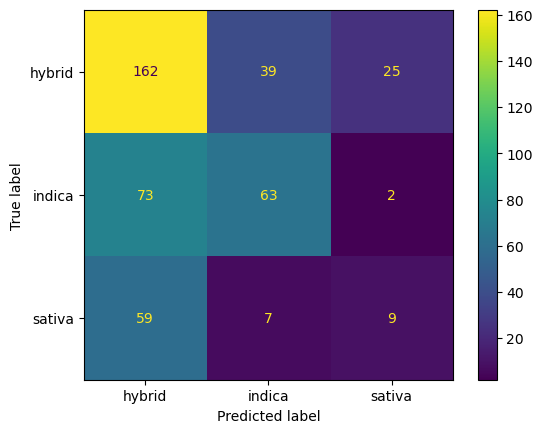

In [175]:
#get confusion matrix

# predict y's on X_test
y_pred = knn_pipeline.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
knn_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_pipeline.named_steps['knn_classifier'].classes_)
knn_cm.plot()


**Q3**

Were your metrics better or worse than in Part One? Why? Which categories were most likely to get mixed up, according to the confusion matrices? Why?

**Part Three: Multiclass from Binary**

Consider two models designed for binary classification: SVC and Logistic Regression.

**Q1**

Fit and report metrics for **OvR** versions of the models. That is, for each of the two model types, create three models:

* Indica vs. Not Indica

* Sativa vs. Not Sativa

* Hybrid vs. Not Hybrid

In [176]:
#create new columns
cannabis_clean['is_indica'] = cannabis_clean['Type'] == 'indica'
cannabis_clean['is_sativa'] = cannabis_clean['Type'] == 'sativa'
cannabis_clean['is_hybrid'] = cannabis_clean['Type'] == 'hybrid'

#convert to binary
cannabis_clean['is_indica'] = cannabis_clean['is_indica'] * 1
cannabis_clean['is_sativa'] = cannabis_clean['is_sativa'] * 1
cannabis_clean['is_hybrid'] = cannabis_clean['is_hybrid'] * 1

<positron-console-cell-176>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-176>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-176>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-176>:7: SettingWithC

**Logistic Regression**

In [177]:
#logistic pipeline
lr_pipeline_logistic = Pipeline(
  [("preprocessing", ct),
  ("logistic_regression", LogisticRegression())]
).set_output(transform="pandas")

**Indica vs. Not Indica**

In [178]:
#variable selection
X = cannabis_clean.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = cannabis_clean["is_indica"]

In [179]:
#tune penalty parameter
Cs = {"logistic_regression__C": [0, .2, .4, .6, .8, 1]}

gscv = GridSearchCV(lr_pipeline_logistic, Cs, cv = 5, scoring='f1')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.f

,logistic_regression__C,scores
3,0.6,0.639782
1,0.2,0.638982
2,0.4,0.638662
4,0.8,0.635047
5,1.0,0.631180


**Sativa vs. Not Sativa**

In [180]:
#variable selection
X = cannabis_clean.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = cannabis_clean["is_sativa"]

In [181]:
#tune penalty parameter
Cs = {"logistic_regression__C": [0, .2, .4, .6, .8, 1]}

gscv = GridSearchCV(lr_pipeline_logistic, Cs, cv = 5, scoring='f1')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.f

,logistic_regression__C,scores
4,0.8,0.405203
5,1.0,0.404736
2,0.4,0.398911
1,0.2,0.391345
3,0.6,0.391296


**Hybrid vs. Not Hybrid**

In [182]:
#variable selection
X = cannabis_clean.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = cannabis_clean["is_hybrid"]

In [183]:
#tune penalty parameter
Cs = {"logistic_regression__C": [0, .2, .4, .6, .8, 1]}

gscv = GridSearchCV(lr_pipeline_logistic, Cs, cv = 5, scoring='f1')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.f

,logistic_regression__C,scores
2,0.4,0.641359
1,0.2,0.640883
5,1.0,0.639208
3,0.6,0.638472
4,0.8,0.637453


**SVC**

In [184]:
#pipeline
lr_pipeline_support_vector_class = Pipeline(
  [("preprocessing", ct),
  #use kernel = 'linear' like from practice activity, still want to tune C
  ("support_vector_class", SVC(C = 0.1, kernel = 'linear'))]
).set_output(transform="pandas")

**Indica vs. Not Indica**

In [185]:
#variable selection
X = cannabis_clean.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = cannabis_clean["is_indica"]

In [186]:
#tune c
cs = {"support_vector_class__C": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_support_vector_class, cs, cv = 5, scoring='f1')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

,support_vector_class__C,scores
1,0.010,0.664868
2,0.100,0.656550
3,1.000,0.614112
4,10.000,0.613103
5,100.000,0.613103
0,0.001,0.432492


**Sativa vs. Not Sativa**

In [187]:
#variable selection
X = cannabis_clean.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = cannabis_clean["is_sativa"]

In [188]:
#tune c
cs = {"support_vector_class__C": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_support_vector_class, cs, cv = 5, scoring='f1')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

KeyboardInterrupt: 

**Hybrid vs. Not Hybrid**

In [ ]:
#variable selection
X = cannabis_clean.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = cannabis_clean["is_hybrid"]

In [189]:
#tune c
cs = {"support_vector_class__C": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_support_vector_class, cs, cv = 5, scoring='f1')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

,support_vector_class__C,scores
3,1.000,0.395924
4,10.000,0.395679
5,100.000,0.395679
2,0.100,0.306140
1,0.010,0.004819
0,0.001,0.000000


**Q2**

Which of the six models did the best job distinguishing the target category from the rest? Which did the worst? Does this make intuitive sense?

**Q3**

Fit and report metrics for OvO versions of the models. That is, for each of the two model types, create three models:

* Indica vs. Sativa

* Indica vs. Hybrid

* Hybrid vs. Sativa



In [190]:
#data creation
indica_sativa = cannabis_clean[(cannabis_clean['Type'] == 'indica') | (cannabis_clean['Type'] == 'sativa')]

indica_hybrid = cannabis_clean[(cannabis_clean['Type'] == 'indica') | (cannabis_clean['Type'] == 'hybrid')]

hybrid_sativa = cannabis_clean[(cannabis_clean['Type'] == 'hybrid') | (cannabis_clean['Type'] == 'sativa')]

**Logistic Regression**

**Indica vs. Sativa**

In [191]:
#variable selection
X = indica_sativa.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = indica_sativa["Type"]

In [192]:
#tune penalty parameter
Cs = {"logistic_regression__C": [0, .2, .4, .6, .8, 1]}

gscv = GridSearchCV(lr_pipeline_logistic, Cs, cv = 5, scoring='f1')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

InvalidParameterError: The 'C' parameter of LogisticRegression must be a float in the range (0.0, inf]. Got 0 instead.

**Indica vs. Hybrid**

In [ ]:
#variable selection
X = indica_hybrid.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = indica_hybrid["Type"]

In [ ]:
#tune penalty parameter
Cs = {"logistic_regression__C": [0, .2, .4, .6, .8, 1]}

gscv = GridSearchCV(lr_pipeline_logistic, Cs, cv = 5, scoring='f1')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

**Hybrid vs. Sativa**

In [193]:
#variable selection
X = hybrid_sativa.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = hybrid_sativa["Type"]

In [194]:
#tune penalty parameter
Cs = {"logistic_regression__C": [0, .2, .4, .6, .8, 1]}

gscv = GridSearchCV(lr_pipeline_logistic, Cs, cv = 5, scoring='f1')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,

InvalidParameterError: The 'C' parameter of LogisticRegression must be a float in the range (0.0, inf]. Got 0 instead.

**Q4**

Which of the six models did the best job distinguishing at differentiating the two groups? Which did the worst? Does this make intuitive sense?

**Q5**

Suppose you had simply input the full data, with three classes, into the LogisticRegression function. Would this have automatically taken an “OvO” approach or an “OvR” approach?

What about for SVC?

Note: You do not actually have to run code here - you only need to look at sklearn’s documentation to see how these functions handle multiclass input.

**QUESTIONS**

* Should we be tuning if it takes 10+ minutes to run? (the parts that seem to take the longer are for part 2 Q2)

* For part 3 when we are fitting do we need to report anything other than the metric like a (confusion matrix)

* For part 1 it says to choose a metric, is that just the scoring metric used?

* Do we need to report coefficients for any part of the lab?

* Did I do the models for part 3 right?